In [2]:
import sys
import os 
import fnmatch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes 
from scipy.optimize import curve_fit 
from scipy.stats import norm
import numpy as np
current_directory = os.getcwd()
data_directory = current_directory+"\\extracted_data\\"
import pandas as pd
import uproot
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\utils')
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\tracking')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display
from time_correction import *
# from find_muon_decay import find_muon_decay
from statistics import mean 

In [4]:
# Create the tracks form the raw datas and the indices events selected previously with data_creation_time

run ='run_000011'
data_storage = current_directory+"\\extracted_data\\"
raw_data_directory = "C:\\Users\\Pascal\\Desktop\\TP4a\\data"
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\") #warning, the df_hits is a list of events, not of hits !
good_candidates = np.loadtxt(data_storage+"events_indices_"+run+".txt") #load the indices of the events selected as good candidates

#Now we will extract the hits of each events and create tracks for each of them

%matplotlib inline
tracks = []
for i in range(len(good_candidates)) :
    event = df_hits.loc[good_candidates[i]] #select the event i among the good candidates
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,j) for j in range(event['n_hits' ])] #create an array "hits" with the hits of the event i (iteration on j inside the event)
    # print (hits)    
    Track = Track3D(hits) #creation of a track with the hits of the event i
    tracks.append(time_correction(Track)) # add the track i to the tracks array witg geomertical time correction
    # print(track)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\Pascal\\Desktop\\TP4a\\datarun_000011\\'

In [6]:
#TEST CHECK
# observe the timestamps corrected

time_check = [None]*len(tracks)
for t in range(len(tracks)) :
    time_check[t]=[]
    for i in range(len(tracks[t].x.hits)):
        time_check[t].append(tracks[t].x.hits[i].timestamp)
    for j in range(len(tracks[t].y.hits)):
        time_check[t].append(tracks[t].y.hits[i].timestamp)

In [11]:
# # Computation of offsets and time resolution 


# rows = 16
# rows1D = 8
# cols = 24
 
# x_offset = [[0 for _ in range(cols)] for _ in range(rows1D)] # 8x24 matrix
# y_offset = [[0 for _ in range(cols)] for _ in range(rows1D)] # 8x24 matrix


# len_tracks = len(tracks)
# print(len_tracks)

# moy = True #paramter tu choose if an averyage is done on the timestamps of each track or not


# for k in [1,2,3,4,5,6]: #number of iteration of the whole process

#     variance = [None]*len_tracks
#     sigma = [[0 for _ in range(cols)] for _ in range(rows)] # 16x24 matrix
#     number_check = [[0 for _ in range(cols)] for _ in range(rows)] # 16x24 matrix to check the number of tracks concernes by each bars

#     # for the x layers first : **************************************************

#     for i in range(8) :  #itaration on the 8 x-layers
#         for j in range(24) : # iteration on the 24 bars on each layers
#             mu =[]
#             t_dist=[]
#             for t in range(len_tracks) : #iteration on all the tracks selected

#                 if tracks[t].x.hits[i].coord[0]-1==j : #does the track goes through the j bar ?
#                     # print(tracks[t].x.hits[i].coord[0])
#                     number_check[i][j] += 1
#                     t_track = [] #initialisation of the array with timestamp of other bars where the track goes through

#                     t_bar =  tracks[t].x.hits[i].timestamp - x_offset[i][j] #initialisation of timestamp of bar i (xbar)
                    
#                     # for z in (range(len(tracks[t].x.hits))) : #iteration on the 7 other x-layers 
#                     for z in (range(8)) : #iteration on the 7 other x-layers 
#                         if z != i : #we exclude the i layer
#                             coordj = tracks[t].x.hits[z].coord[0]-1 #coordinate x where the track goes through on the z layer
#                             t_track.append(tracks[t].x.hits[z].timestamp - x_offset[z][coordj]) 
#                     for z in (range(8)) :  #iteration on the 8 other y-layers
#                             coordj = tracks[t].y.hits[z].coord[0]-1 #coordinate y where the track goes through on the z layer
#                             t_track.append(tracks[t].y.hits[z].timestamp - y_offset[z][coordj])
                        
                  
#                     t_track_tot, variance[t] = norm.fit(t_track) #variable variance help to follow the convergence of the algorythm
#                     if moy : 
#                         t_track_av=mean(t_track)
#                         t_dist.append(t_track_av - t_bar)
#                     else :
#                          for l in range(len(t_track)):
#                             t_dist.append(t_track[l-t_bar])
                
                

#             mu, sigma[i][j] = norm.fit(t_dist)
            

#             x_offset[i][j]= mu

#     # **************************************************************************************************************

#     # for the y layers now :

#     for i in range(8) :  #itaration on the 8 x-layers
#             for j in range(24) : # iteration on the 24 bars on each layers
#                 mu =[]
#                 t_dist=[]
#                 for t in range(len_tracks) : #iteration on all the tracks selected

#                     if tracks[t].y.hits[i].coord[0]-1==j : #does the track goes through the j bar ?
#                         number_check[i+8][j] += 1

#                         t_track = [] #initialisation of the array with timestamp of other bars where the track goes through

#                         t_bar =  tracks[t].y.hits[i].timestamp - y_offset[i][j] #initialisation of timestamp of bar i (xbar)
                        
#                         for z in (range(8)) : #iteration on the 7 other y-layers 
#                             if z != i : #we exclude the i layer
#                                 coordj = tracks[t].y.hits[z].coord[0]-1 #coordinate y where the track goes through on the z layer
#                                 t_track.append(tracks[t].y.hits[z].timestamp - y_offset[z][coordj]) 
#                         for z in range(8) :  #iteration on the 8 other x-layers
#                                 coordj = tracks[t].x.hits[z].coord[0]-1 #coordinate x where the track goes through on the z layer
#                                 t_track.append(tracks[t].x.hits[z].timestamp -x_offset[z][coordj]) 
                            
#                         t_track_tot, variance[t] = norm.fit(t_track) #variable variance help to follow the convergence of the algorythm

#                         if moy :
#                             t_track_av=mean(t_track)
#                             t_dist.append(t_track_av - t_bar)
#                         else :
#                             for l in range(len(t_track)):
#                                  t_dist.append(t_track[l-t_bar])

#                 mu, sigma[i+8][j] = norm.fit(t_dist)
                

#                 y_offset[i][j]= mu

#             # *************************************************************************************************************

#     # computation of variance of the algorithm for each process iteration k

#     variance_tot = mean(variance)
#     print(str(k)+"_variance = " +str(variance_tot))
#     sigma_temp = [None]*8
#     for i in range(8) :
#         sigma_temp[i] = mean(sigma[0:23][i])
#     sigma_tot = mean(sigma_temp)
#     print(str(k)+"_sigma = "+str(sigma_tot))
#     # print(x_offset)
#     # print(y_offset)

   



10243
1_variance = 0.4127808970905714
1_sigma = 0.27598253584201204
2_variance = 0.5745777930291349
2_sigma = 0.2827052325938338
3_variance = 0.7632546882877058
3_sigma = 0.28824649917708245
4_variance = 0.972662577139618
4_sigma = 0.2924935114594733
5_variance = 1.2007563460148682
5_sigma = 0.29569877545313694
6_variance = 1.4471992707538437
6_sigma = 0.29815599540277976


In [27]:
countX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muXF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

countY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muYF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

iterations = 10

for it in range(iterations):
    for i in range(24):
        for j in range(8):
            time = []
            for t in tracks:
                for hx in t.x.hits:
                    if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
                        countX[i][j] += 1
                        tbar = hx.timestamp
                        for hxp in t.x.hits + t.y.hits:
                            if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                                time.append(hxp.timestamp-tbar-muXF[i][j])
            muX[i][j], sigmaX[i][j] = norm.fit(time)
            time = []
            for t in tracks:
                for hy in t.y.hits:
                    if hy.coord[0]-1 == i and hy.coord[1]-1 == j: # if its the ith jth bar in x
                        countY[i][j] += 1
                        tbar = hy.timestamp
                        for hyp in t.y.hits + t.x.hits:
                            if(not(hyp.coord[0]-1 == i and hyp.coord[1]-1 == j and not(hxp.is_sidex))):
                                time.append(hyp.timestamp-tbar-muYF[i][j])
            muY[i][j], sigmaY[i][j] = norm.fit(time)
muXF = muXF + muX
muYF = muYF + muY

In [28]:
## Plot the histogram and gaussian fit ***************************************************
# Plot the histogram
plt.hist(t_dist, bins=25, density=True, alpha=0.6, color='g')
# # Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma[i][j] )
plt.plot(x, p, 'k', linewidth=2)
# # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# # plt.title(title)

plt.show() 

NameError: name 't_dist' is not defined

c:\Users\eliot\mambaforge\envs\ecal-env\Lib\site-packages\matplotlib\axes\_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\eliot\mambaforge\envs\ecal-env\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

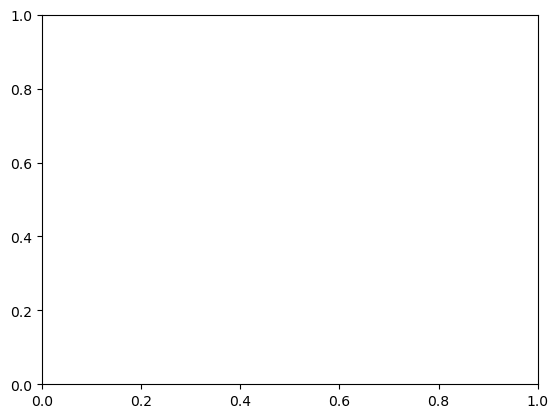

In [36]:
# for i in range(8) :  #itaration on the 8 x-layers
#   for j in range(24) : # iteration on the 24 bars on each layers
    ## Plot the histogram and gaussian fit ***************************************************
      # Plot the histogram
    plt.hist(t_dist, bins=25, density=True, alpha=0.6, color='g')
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma[23][15] )
    plt.plot(x, p, 'k', linewidth=2)
    # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    # plt.title(title)

    plt.show() 
          #******